Paquetes

In [ ]:
import torch
import numpy as np
from torch import nn
import torchvision
from collections import OrderedDict
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import utils

# Definicion de modelo

In [ ]:
class VGG(nn.Module):
    """
    Standard PyTorch implementation of VGG. Pretrained imagenet model is used.
    """
    def __init__(self):
        super().__init__()
    
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),
            
            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000)
        )

        # We need these for MaxUnpool operation
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

Cargar pesos

In [ ]:
vgg = VGG()
temp = torchvision.models.vgg16(pretrained=True)
vgg.load_state_dict(temp.state_dict())

Testeo

In [ ]:
def visualizar_imagen(imagen):
    imagen = imagen.numpy()
    imagen = imagen/imagen.max()
    imagen = np.clip(imagen, 0, 1)
    return Image.fromarray(np.uint8(imagen*255))

Imagen de prueba

In [ ]:
input_image = Image.open("dog.jpg")
input_image.resize((224, 224))

Transformaciones imagen -> tensor

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    vgg.to('cuda')

In [ ]:
input_batch.shape

## Vista interna del modelo

Para visualizar los filtros:

In [127]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        img = grid.numpy().transpose((1, 2, 0))
        width = 200
        height = img.shape[0] * width // img.shape[1]

        return Image.fromarray(np.uint8(img*255)).resize((width,height), resample=Image.Resampling.NEAREST)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Iniciar en capa 0

In [214]:
j=-1
x = input_batch

In [248]:
if j == len(vgg.features) -1:
    print("Features listas. No seguir.")
with torch.no_grad():

    layer = vgg.features[j]

    if isinstance(layer, nn.MaxPool2d):
        x, location = layer(x)
    else:
        x = layer(x)
    
    # Visualizar las convoluciones
    if isinstance(layer, nn.Conv2d):
        filtro = layer.weight.data.clone().cpu()
        filtroVis = visTensor(filtro, ch=0, allkernels=False)

    vis = x[0].cpu()
    images = [visualizar_imagen(i) for i in vis]
    images = images[:10]
    
    imgVis = image_grid(images, 2, 5)

    print(j)
    print(layer)
    print("Dimension tensor: ", x.shape)
    print("Dimension filtros: ",filtro.shape)
    j += 1

imgVis

IndexError: index 31 is out of range

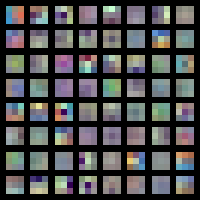

In [218]:
filtroVis

In [ ]:
x = x.view(x.size()[0], -1)
x = vgg.classifier(x)
output = x

# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
probabilities = torch.nn.functional.softmax(output[0], dim=0)

with torch.no_grad():
    for layer in vgg.features:
        if isinstance(layer, nn.MaxPool2d):
            x, location = layer(x)
        else:
            x = layer(x)
        
        # Visualizar las convoluciones
        if isinstance(layer, nn.Conv2d):
            filtro = layer.weight.data.clone().cpu()
            visTensor(filtro, ch=0, allkernels=False)

        vis = x[0].cpu()
        images = [visualizar_imagen(i) for i in vis]
        
        i = 0
        for i, image in enumerate(images):
            i += 1
            if i > 10:
                break
            image.save('feature_maps/output_{}.jpg'.format(i))

        print("")
    
    x = x.view(x.size()[0], -1)
    x = vgg.classifier(x)
    output = x

# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Categorias

In [ ]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())
